In [12]:
%load_ext autoreload
from ddls.plotting.plotting import plot_line, plot_bar, plot_hist, PlotAesthetics

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# set paths to agent(s)

base_folder = '/scratch/datasets/ddls/sims/'

# base_name = 'job_placing'
# # ids = [108]
# ids = [108, 116]

base_name = 'ramp_job_placement_shaping'
agent_to_id = {
    
    # 'Random': 349,
    # 'First Fit': 350,
    # 'Last Fit': 351,
    # # 'RL': f'{base_folder}/{base_name}/{base_name}_{348}/checkpoints/checkpoint_000002/',
    # 'RL': 363,
    
    # AlexNet
    # 'First Fit': 381,
    # 'RL': f'{base_folder}/{base_name}/{base_name}_{385}/checkpoints/checkpoint_000006/',
    
    # Small graphs (image classification and NMT)
    'First Fit': 412,
    
}

In [22]:
# load data

episode_metrics = {
    'num_jobs_arrived',
    'num_jobs_completed',
    'num_jobs_blocked',
}

episode_completion_metrics = {
    'job_completion_time',
    'job_communication_overhead_time',
    'job_computation_overhead_time',
    'jobs_completed_num_nodes',
    'jobs_completed_num_edges',
    'jobs_completed_total_operation_memory_cost',
    'jobs_completed_total_dependency_size',
}

episode_blocked_metrics = {
    'jobs_blocked_num_nodes',
    'jobs_blocked_num_edges',
    'jobs_blocked_total_operation_memory_cost',
    'jobs_blocked_total_dependency_size',
}

# 'jobs_blocked_causes', # TODO: Process strings properly below when plotting
step_metrics = set()

agent_to_episode_stats_dict = defaultdict(list)
agent_to_episode_completion_stats_dict = defaultdict(list)
agent_to_episode_blocked_stats_dict = defaultdict(list)

agent_to_step_stats_dict = defaultdict(list)

for agent, _id in agent_to_id.items():
    if isinstance(_id, int):
        # use int id to generate string dir to data
        agent_dir = base_folder + f'{base_name}/{base_name}_{_id}/'
    else:
        # string dir to data already provided
        agent_dir = _id
    if os.path.isdir(agent_dir):
        print(f'\nLoading validation data from {agent_dir[:-1]}...')
            
        completion_stats_found, blocked_stats_found = False, False

        # load episode stats
        with gzip.open(agent_dir+'episode_stats.pkl', 'rb') as f:
            episode_stats = pickle.load(f)
        for metric, result in episode_stats.items():
            if metric in episode_metrics:
                try:
                    agent_to_episode_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_episode_stats_dict[metric].append(result)
            elif metric in episode_completion_metrics:
                completion_stats_found = True
                try:
                    agent_to_episode_completion_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_episode_completion_stats_dict[metric].append(result)
            elif metric in episode_blocked_metrics:
                blocked_stats_found = True
                try:
                    agent_to_episode_blocked_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_episode_blocked_stats_dict[metric].append(result)
            else:
                raise Exception(f'Unrecognised metric {metric}')
        agent_to_episode_stats_dict['Agent'].append(agent)
        if completion_stats_found:
            agent_to_episode_completion_stats_dict['Agent'].append(agent)
        if blocked_stats_found:
            agent_to_episode_blocked_stats_dict['Agent'].append(agent)

        # load step stats
        with gzip.open(agent_dir+'step_stats.pkl', 'rb') as f:
            step_stats = pickle.load(f)
        for metric, result in step_stats.items():
            try:
                agent_to_step_stats_dict[metric].extend(result)
            except TypeError:
                agent_to_step_stats_dict[metric].append(result)
            step_metrics.add(metric)
        agent_to_step_stats_dict['Agent'].extend([agent for _ in range(len(result))])
        
        print(f'Checkpoints loaded from {agent_dir[:-1]}.')
    else:
        print(f'\nNo checkpoints/ folder found in {agent_dir[:-1]}')
       
print(f'\nEpisode stats:')
# print(agent_to_episode_stats_dict)
episode_stats_df = pd.DataFrame(agent_to_episode_stats_dict)
display(episode_stats_df)
# print(agent_to_episode_completion_stats_dict)
episode_completion_stats_df = pd.DataFrame(agent_to_episode_completion_stats_dict)
display(episode_completion_stats_df)
# print(agent_to_episode_blocked_stats_dict)
episode_blocked_stats_df = pd.DataFrame(agent_to_episode_blocked_stats_dict)
display(episode_blocked_stats_df)

print(f'\nStep stats:')
# print(agent_to_step_stats_dict)
# for key, val in agent_to_step_stats_dict.items():
#     print(f'{key} -> {len(val)} vals')
step_stats_df = pd.DataFrame(agent_to_step_stats_dict)
display(step_stats_df)


Loading validation data from /scratch/datasets/ddls/sims/ramp_job_placement_shaping/ramp_job_placement_shaping_412...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_placement_shaping/ramp_job_placement_shaping_412.

Episode stats:


,num_jobs_arrived,num_jobs_completed,num_jobs_blocked,Agent
0,1000.0,700.0,300.0,First Fit


,job_completion_time,job_communication_overhead_time,job_computation_overhead_time,jobs_completed_num_nodes,jobs_completed_num_edges,jobs_completed_total_operation_memory_cost,jobs_completed_total_dependency_size,Agent
0,20508.893156,20508.893156,20508.893156,188.16,453.405714,1.890250e+10,2.912054e+10,First Fit


,jobs_blocked_num_nodes,jobs_blocked_num_edges,jobs_blocked_total_operation_memory_cost,jobs_blocked_total_dependency_size,Agent
0,98.253333,115.306667,8.068350e+09,7.404693e+09,First Fit



Step stats:


,action,reward,step_counter,step_start_time,mean_num_mounted_workers,mean_num_mounted_channels,mean_compute_throughput,mean_comm_throughput,mean_cluster_throughput,mean_compute_overhead_frac,mean_comm_overhead_frac,mean_mounted_worker_utilisation_frac,mean_cluster_worker_utilisation_frac,num_jobs_completed,num_jobs_running,num_jobs_arrived,num_jobs_blocked,step_end_time,job_queue_length,Agent
0,2,-0.253127,0,0.0,2.0,2.0,1.668613e+05,2.315332e+05,3.983945e+05,1.0,1.0,0.987647,0.061728,0,1,1,0,1.000000e+03,1,First Fit
1,2,-0.306912,1,1000.0,4.0,4.0,9.336431e+05,1.370388e+06,2.304031e+06,1.0,1.0,0.901107,0.112638,0,2,1,0,2.000000e+03,1,First Fit
2,2,-0.312923,2,2000.0,6.0,6.0,1.983276e+06,3.144179e+06,5.127455e+06,1.0,1.0,0.867044,0.162571,0,3,1,0,3.000000e+03,1,First Fit
3,2,-0.312923,3,3000.0,8.0,8.0,3.032909e+06,4.917971e+06,7.950879e+06,1.0,1.0,0.850013,0.212503,0,4,1,0,4.000000e+03,1,First Fit
4,2,-0.312923,4,4000.0,10.0,10.0,4.082541e+06,6.691762e+06,1.077430e+07,1.0,1.0,0.839794,0.262436,0,5,1,0,5.000000e+03,1,First Fit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,-0.306912,1676,995000.0,31.0,31.0,1.419568e+07,2.137842e+07,3.557411e+07,1.0,1.0,0.868019,0.840840,1,31,1,0,9.960000e+05,1,First Fit
996,2,-0.253127,1679,996000.0,30.0,30.0,1.328513e+07,2.003201e+07,3.331714e+07,1.0,1.0,0.869444,0.815429,2,45,1,0,9.970000e+05,1,First Fit
997,2,-0.312923,1682,997000.0,28.0,28.0,1.201960e+07,1.840688e+07,3.042649e+07,1.0,1.0,0.856131,0.749252,2,42,1,0,9.980000e+05,1,First Fit
998,2,-0.253679,1683,998000.0,28.0,28.0,1.234679e+07,1.888143e+07,3.122822e+07,1.0,1.0,0.860358,0.752813,0,14,1,0,9.990000e+05,1,First Fit


In [27]:
aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

estimator = np.mean # np.mean np.median

scaling_factor = 1
width_scaling_factor = 1
height_scaling_factor = 1

step_stats_xaxis = 'step_end_time'
step_stats_xaxis_label = 'Time (s)'

legend = 'auto'

ylog = False
xlog = False

ci = None
errcolor = 'gray'
capsize = 0.05


# display bar chart values
display_values = True
# display_values = False
y_offset = 0
# loc = 'bottom'
loc = 'top'




def show_values_on_bars(axs, sigfigs=2, y_offset=0, loc='top'):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            if loc == 'top':
                _x = p.get_x() + p.get_width() / 2
    #             _y = p.get_y() + p.get_height()
    #             _y = p.get_y() + y_offset
                _y = p.get_height() + y_offset
                value = sigfig.round(p.get_height(), sigfigs=sigfigs)
                ax.text(_x, _y, value, ha="center") 
            elif loc == 'bottom':
                _x = p.get_x() + p.get_width() / 2
    #             _y = p.get_y() + p.get_height()
                _y = p.get_y() + y_offset
                value = sigfig.round(p.get_height(), sigfigs=sigfigs)
                ax.text(_x, _y, value, ha="center") 
            else:
                raise Exception(f'Unrecognised loc {loc}')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def barplot(df, metric, x='Agent', display_values=True):
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.barplot(data=df,
                    x=x,
                    y=metric,
                    # order=order,
                    # palette=palette,
                    estimator=estimator,
                    ci=ci,
                    errcolor=errcolor,
                    capsize=capsize)
    g.set_xlabel('Agent')
    g.set_ylabel(metric)
    ax.tick_params(axis='both', which='major', pad=2)
    plt.xticks(fontsize=7.5)
    ax.xaxis.labelpad = 2
    # ax.xaxis.label.set_size(2)
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    if ylog:
        g.set(yscale='log')
    if xlog:
        g.set(xscale='log')
    if display_values:
        show_values_on_bars(ax, sigfigs=3, y_offset=y_offset, loc=loc)
    plt.gcf().patch.set_alpha(0.0)
    plt.show()
    
def lineplot(df, metric):
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.lineplot(data=df, 
                     x=step_stats_xaxis, 
                     y=metric, 
                     hue='Agent', 
                     linewidth=aesthetics.linewidth, 
                     legend=legend)
    # g = sns.scatterplot(data=episode_stats_df, x=xaxis, y=metric, hue='Agent', linewidth=aesthetics.linewidth, legend=legend)
    plt.title(metric)
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    plt.gcf().patch.set_alpha(0.0)
    plt.show()



EPISODE METRICS
Plotting metric num_jobs_blocked -> min=300.0 | max=300.0 | mean=300.0


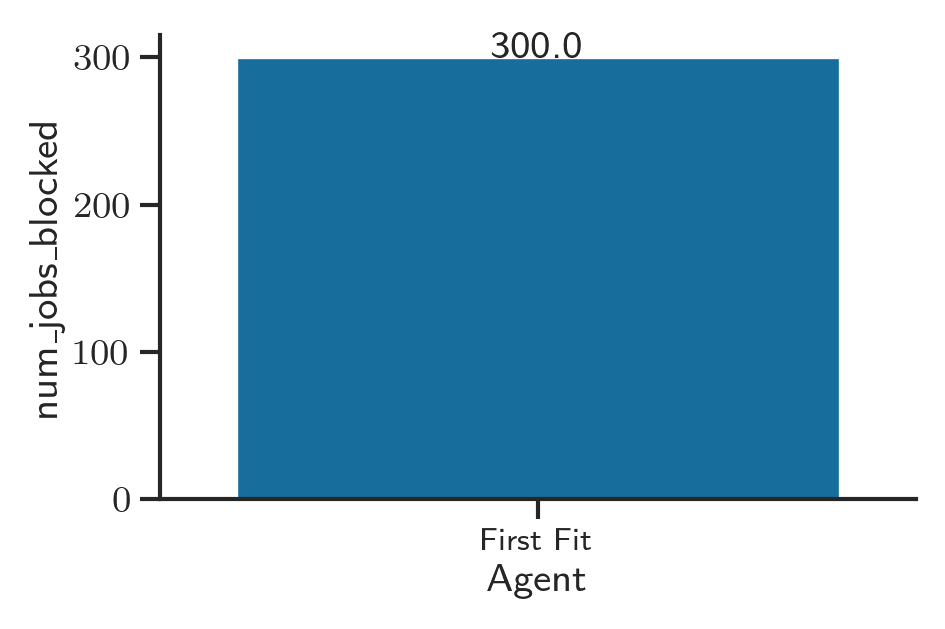

Plotting metric num_jobs_arrived -> min=1000.0 | max=1000.0 | mean=1000.0


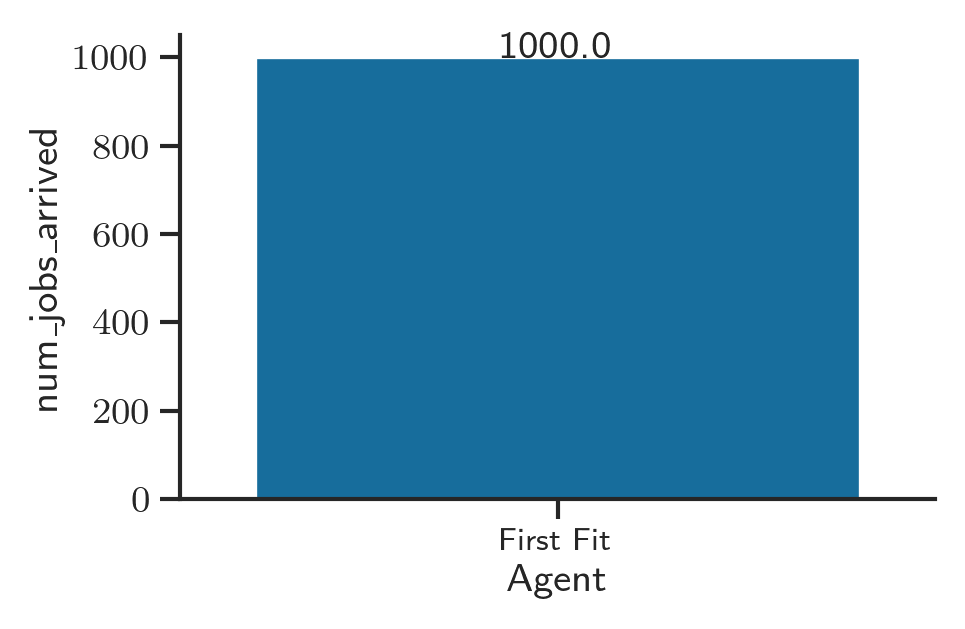

Plotting metric num_jobs_completed -> min=700.0 | max=700.0 | mean=700.0


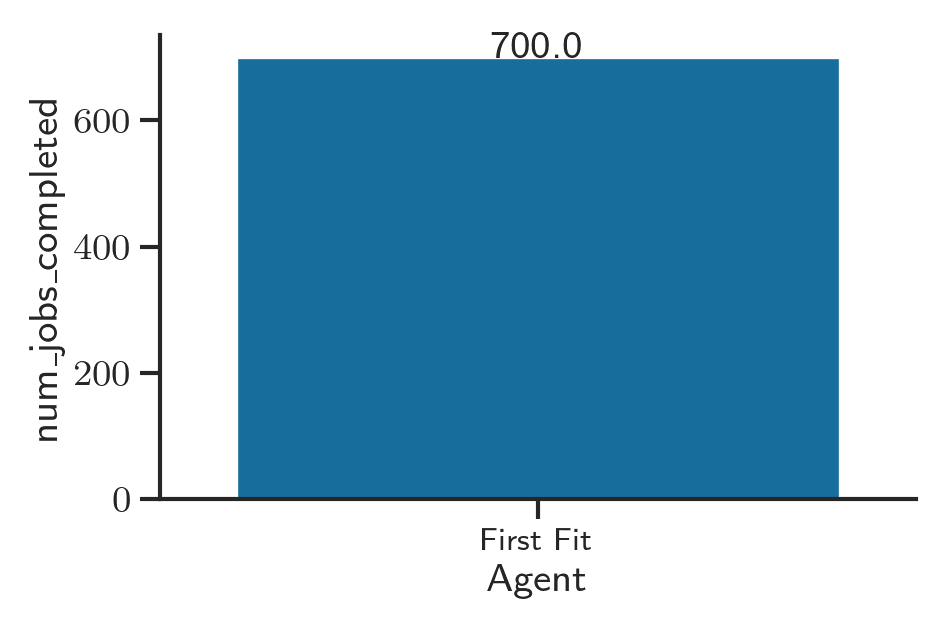

Plotting metric jobs_completed_num_edges -> min=453.4057142857143 | max=453.4057142857143 | mean=453.4057142857143


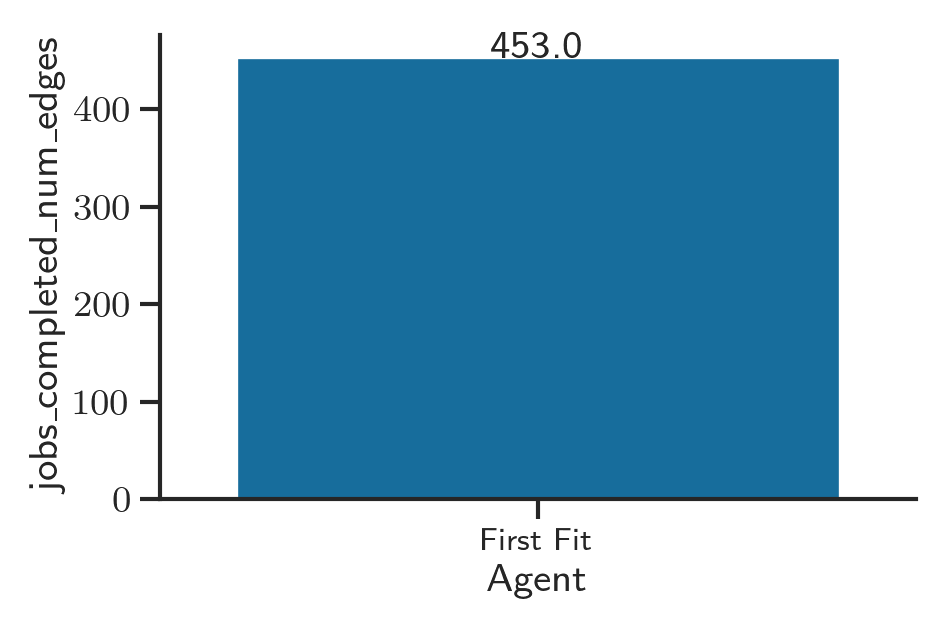

Plotting metric job_completion_time -> min=20508.893155750287 | max=20508.893155750287 | mean=20508.893155750287


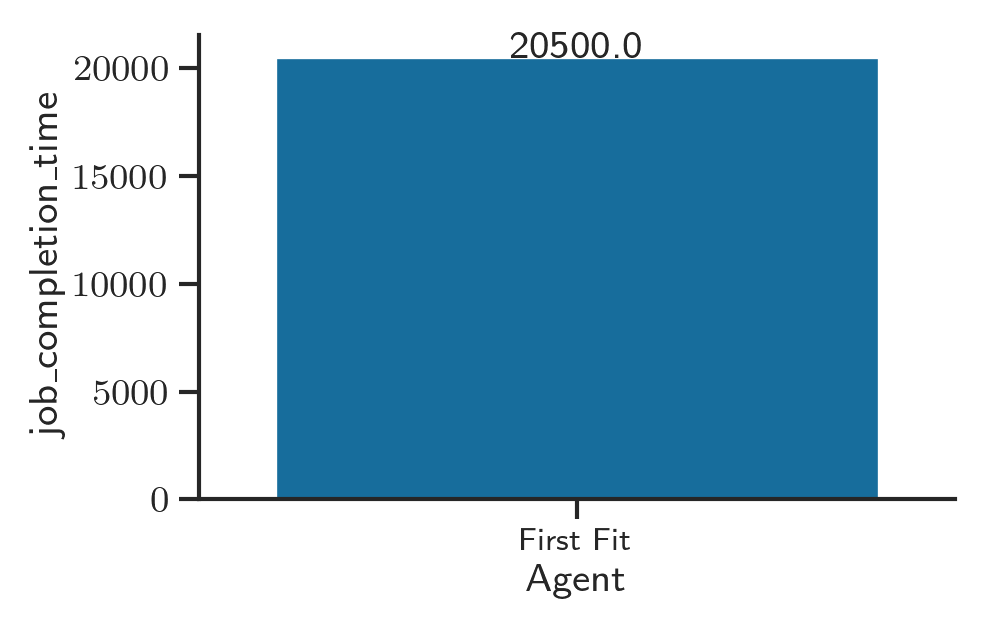

Plotting metric job_computation_overhead_time -> min=20508.89315575029 | max=20508.89315575029 | mean=20508.89315575029


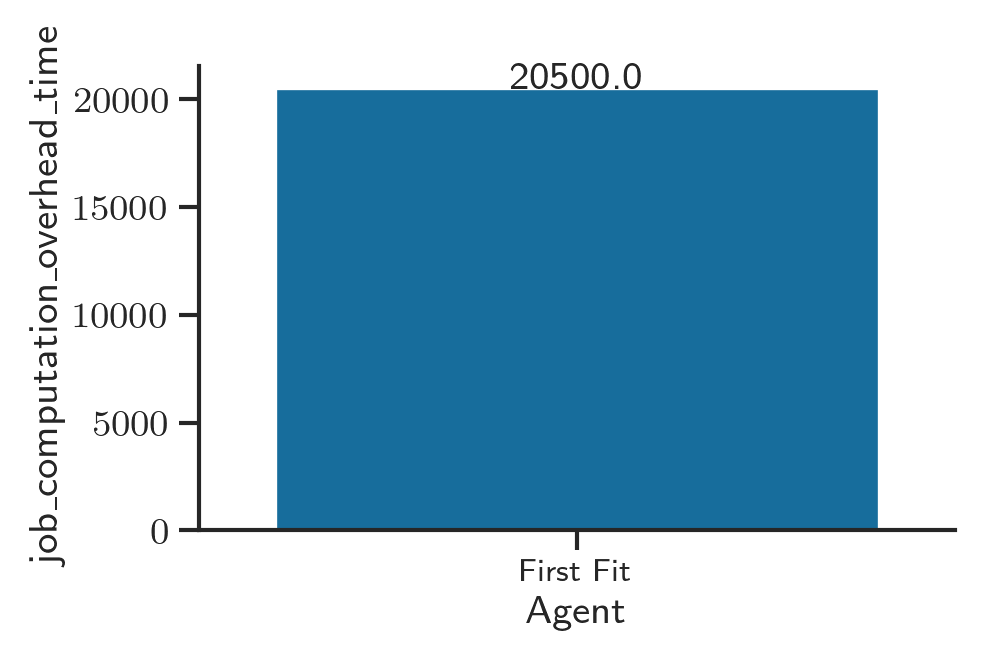

Plotting metric jobs_completed_total_operation_memory_cost -> min=18902495226.46857 | max=18902495226.46857 | mean=18902495226.46857


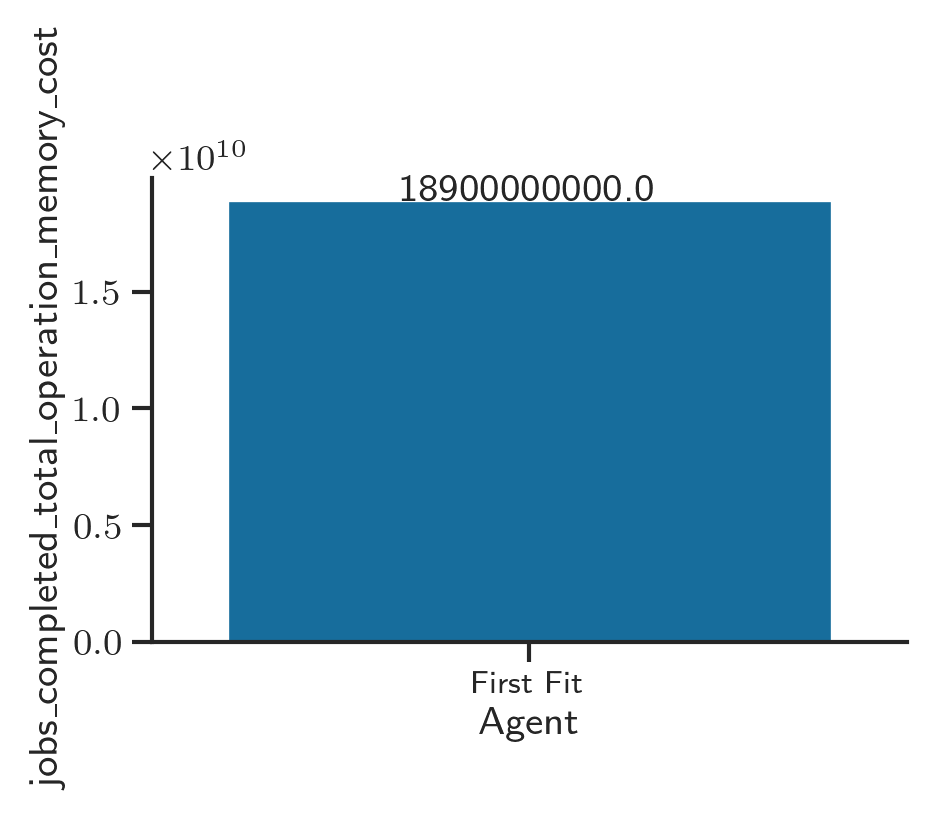

Plotting metric job_communication_overhead_time -> min=20508.89315575029 | max=20508.89315575029 | mean=20508.89315575029


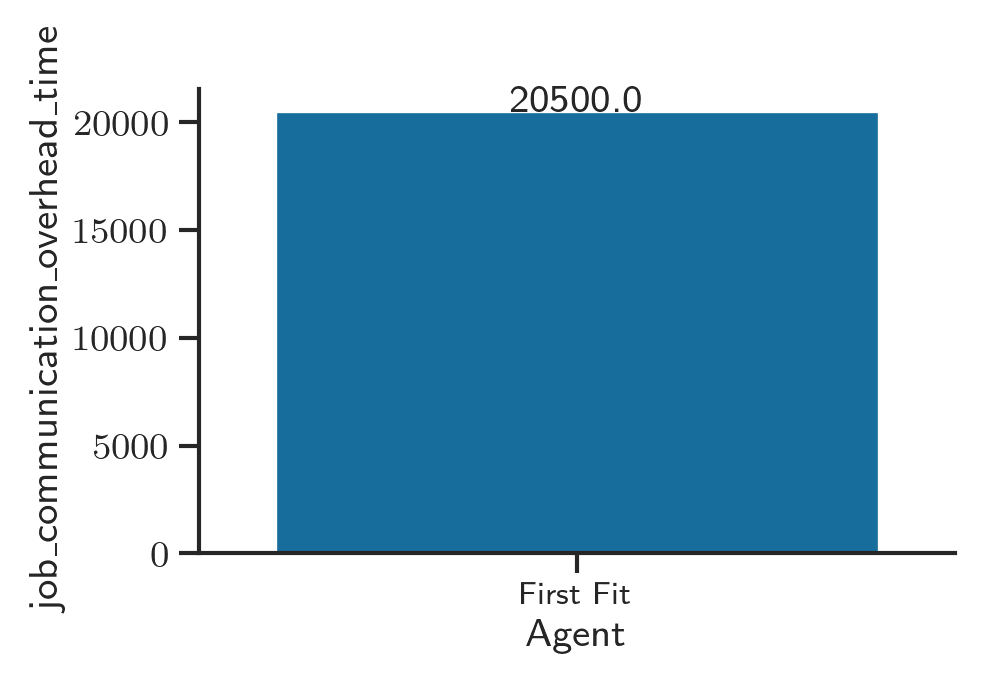

Plotting metric jobs_completed_total_dependency_size -> min=29120544120.89143 | max=29120544120.89143 | mean=29120544120.89143


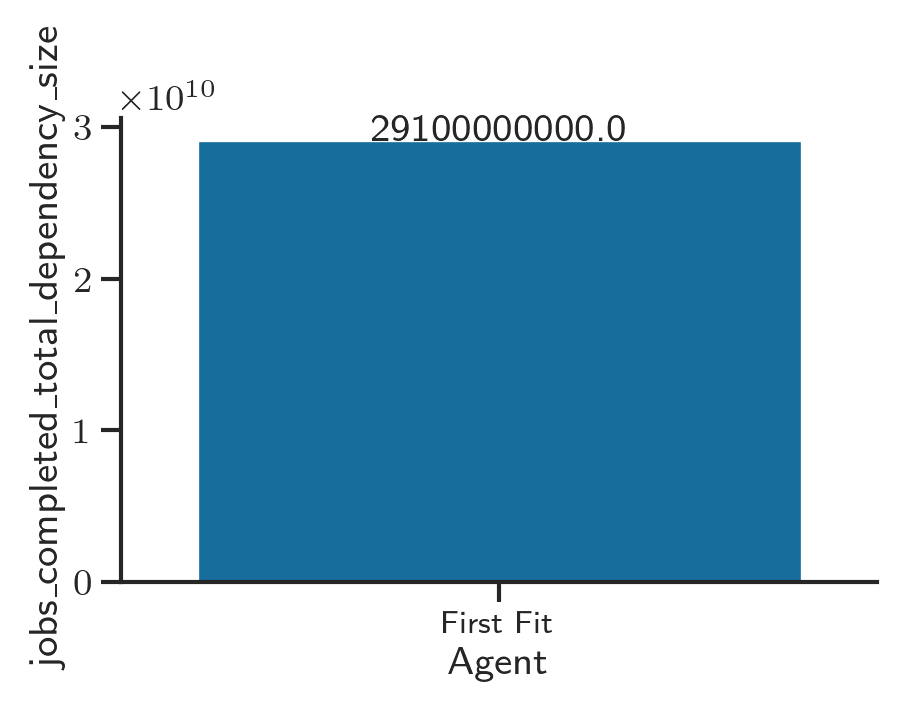

Plotting metric jobs_completed_num_nodes -> min=188.16 | max=188.16 | mean=188.16


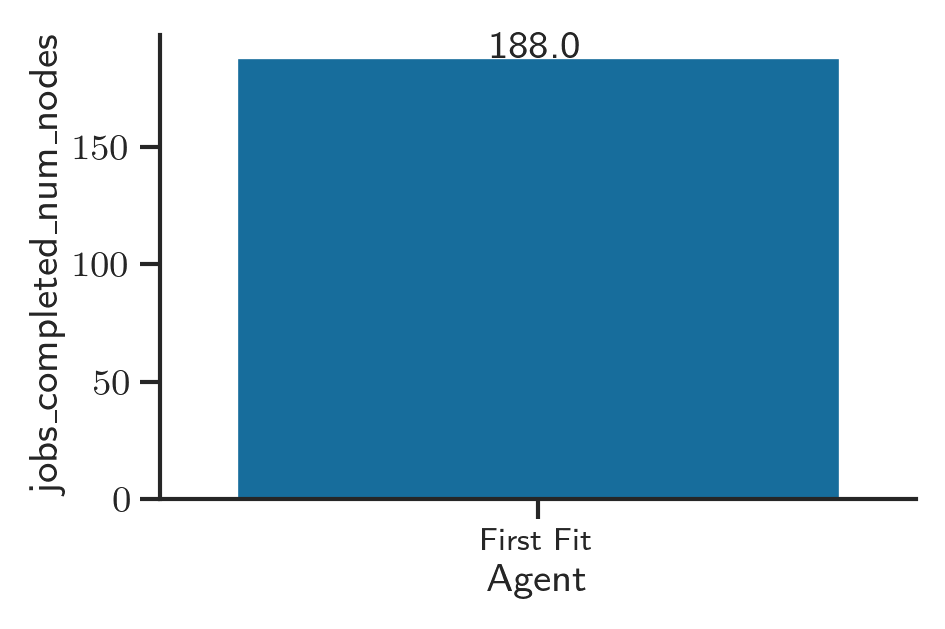

Plotting metric jobs_blocked_num_nodes -> min=98.25333333333333 | max=98.25333333333333 | mean=98.25333333333333


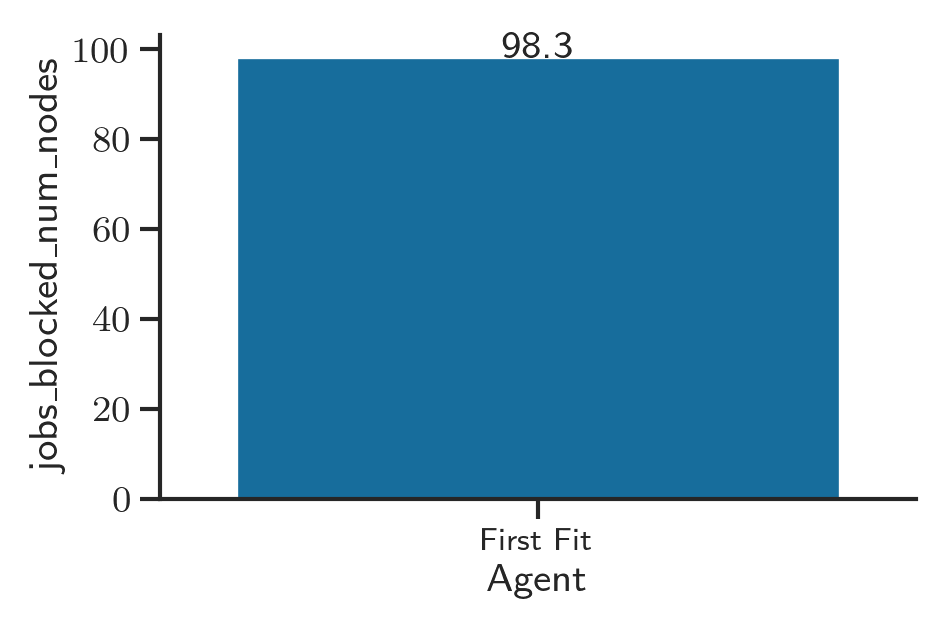

Plotting metric jobs_blocked_num_edges -> min=115.30666666666667 | max=115.30666666666667 | mean=115.30666666666667


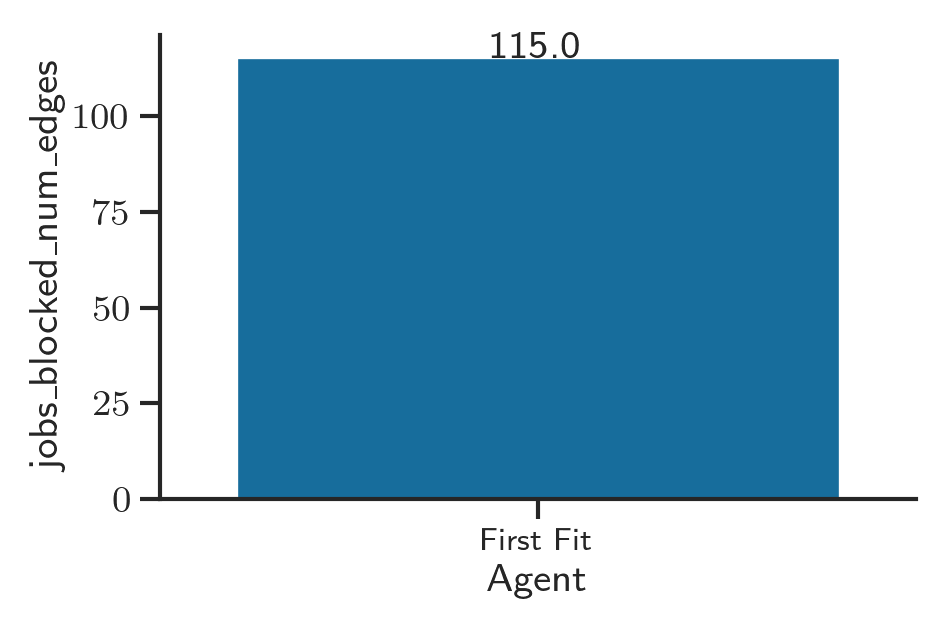

Plotting metric jobs_blocked_total_dependency_size -> min=7404693479.36 | max=7404693479.36 | mean=7404693479.36


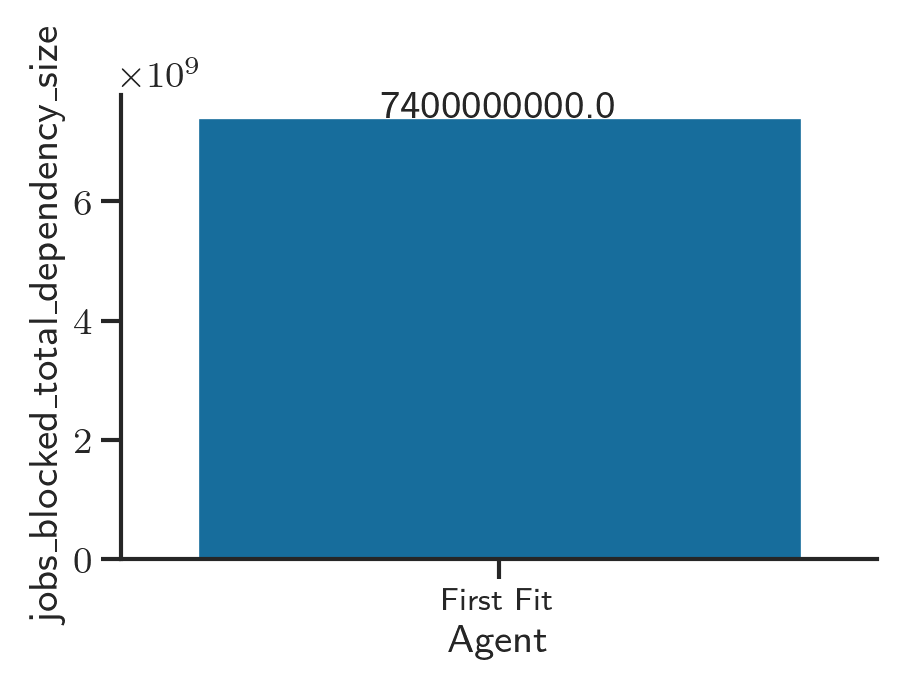

Plotting metric jobs_blocked_total_operation_memory_cost -> min=8068350498.24 | max=8068350498.24 | mean=8068350498.24


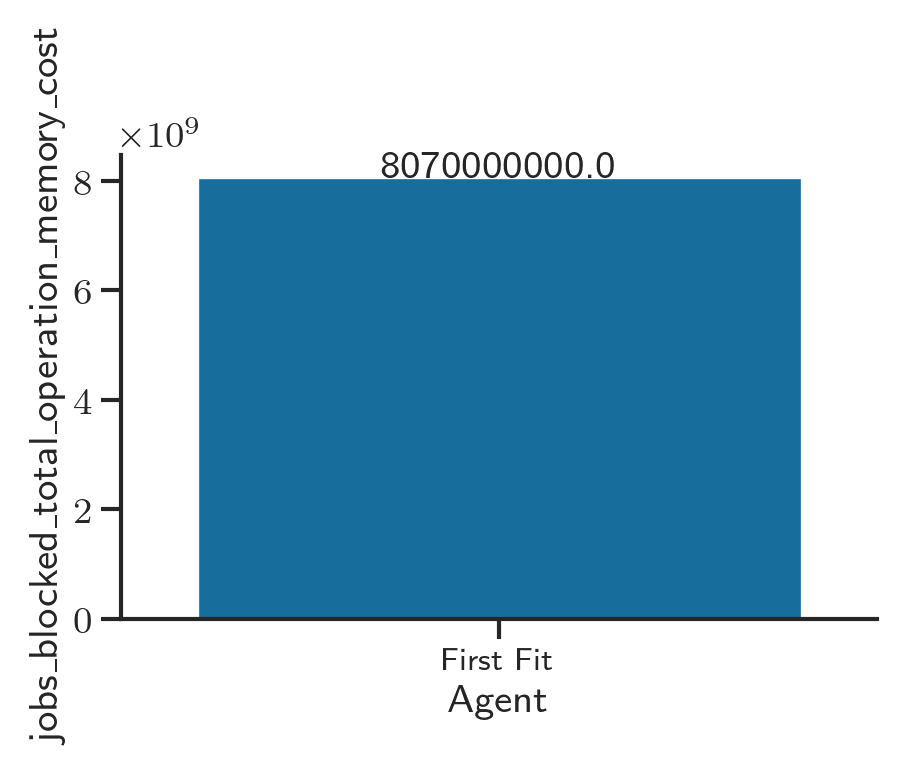



STEP METRICS
Plotting metric mean_cluster_throughput -> min=398394.49409086886 | max=47983367.73481505 | mean=33105771.63774431


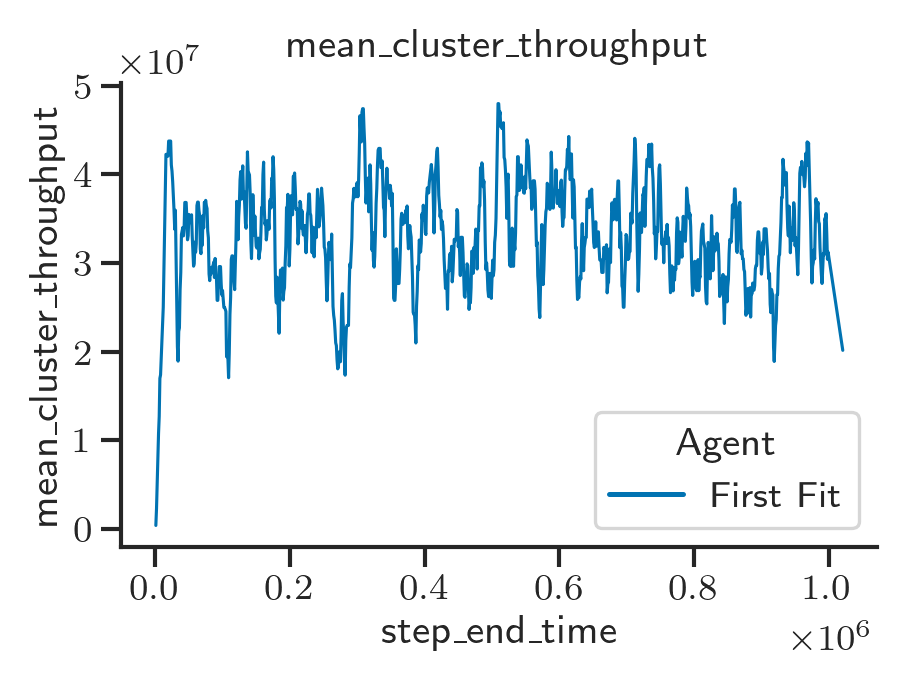

Plotting metric mean_num_mounted_workers -> min=2.0 | max=32.0 | mean=28.357


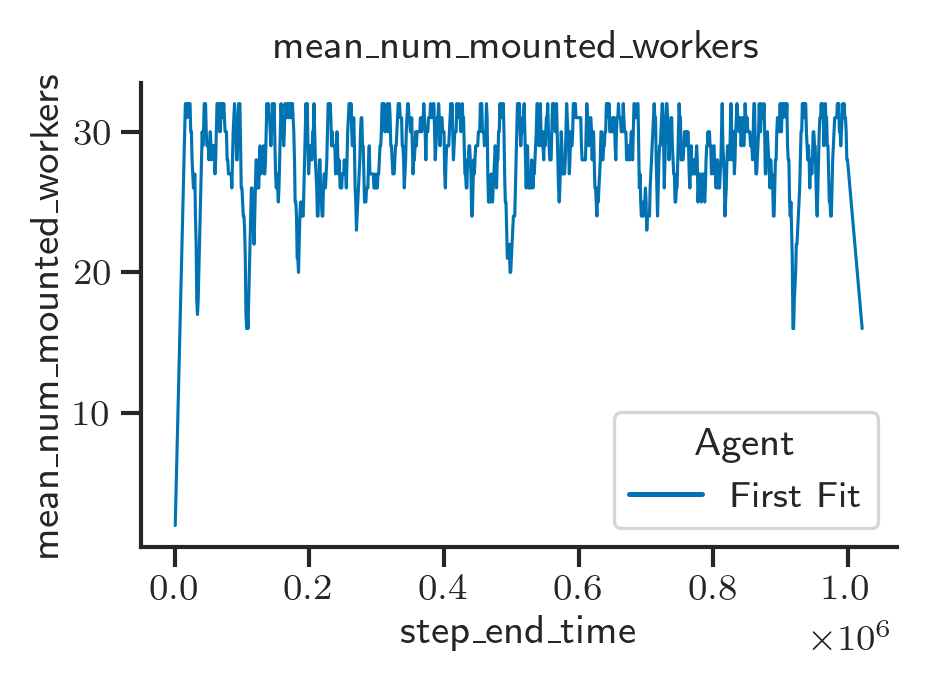

Plotting metric mean_comm_overhead_frac -> min=1.0 | max=1.0 | mean=1.0


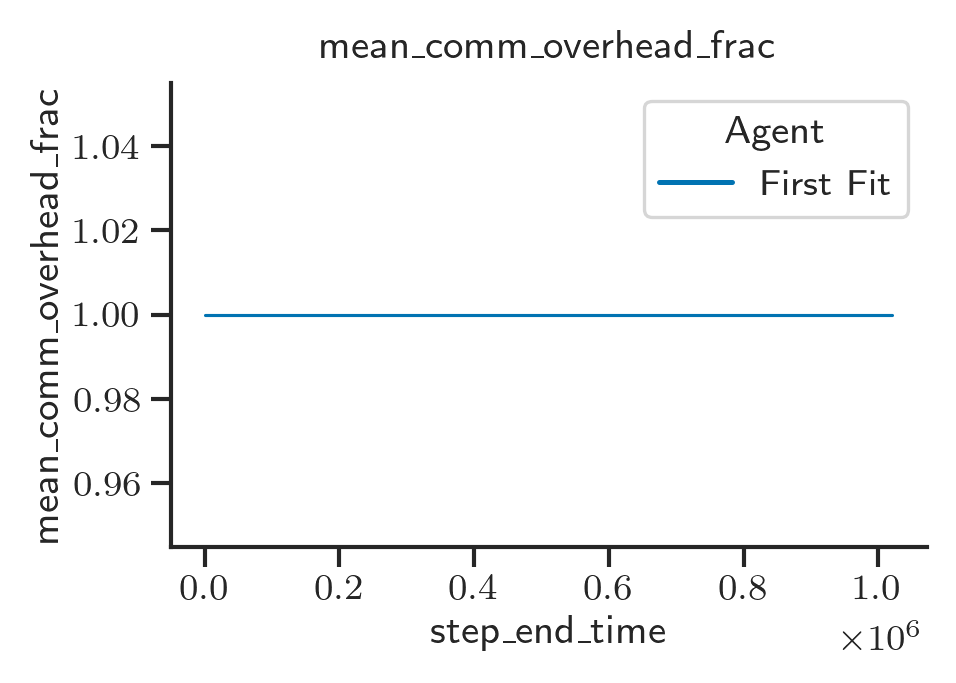

Plotting metric num_jobs_arrived -> min=0 | max=1 | mean=0.999


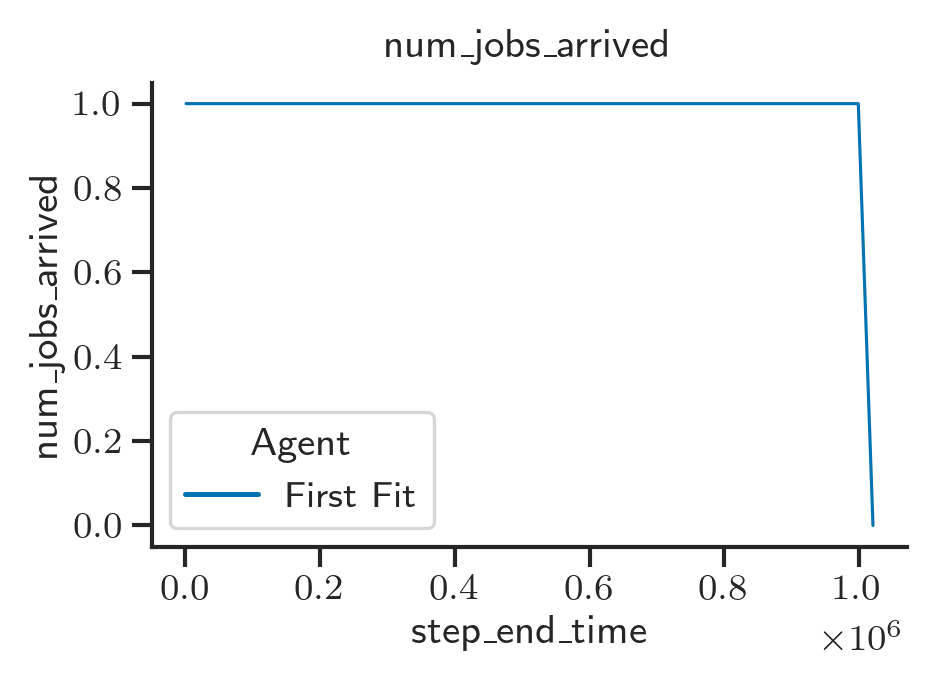

Plotting metric mean_mounted_worker_utilisation_frac -> min=0.833549981728056 | max=0.9876471998766717 | mean=0.8857651575776146


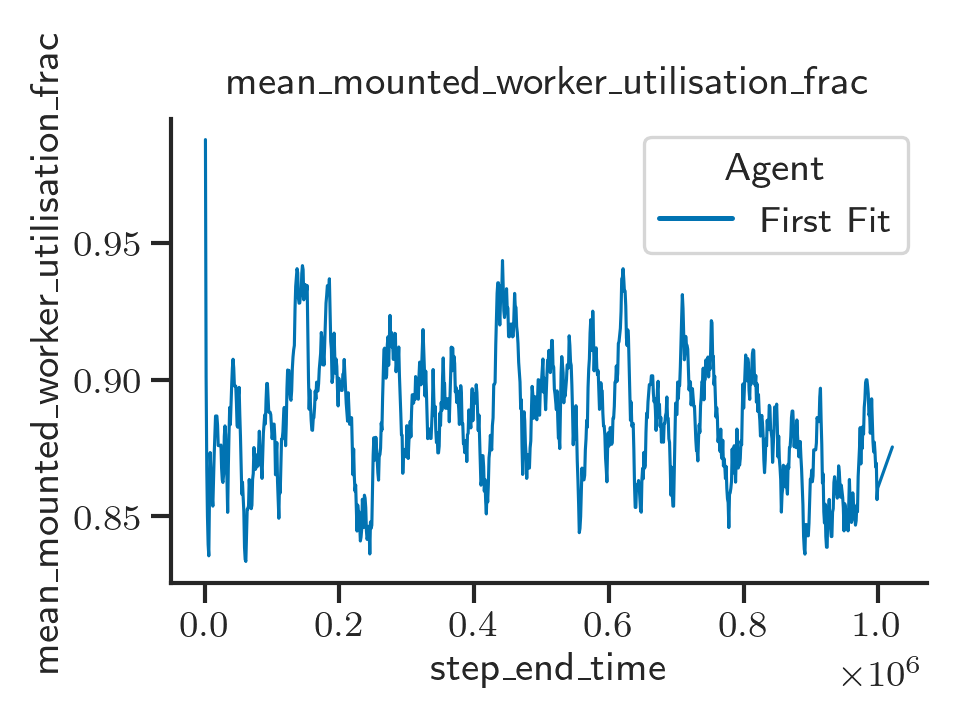

Plotting metric mean_compute_throughput -> min=166861.28505795743 | max=19071052.1639438 | mean=13031345.504831193


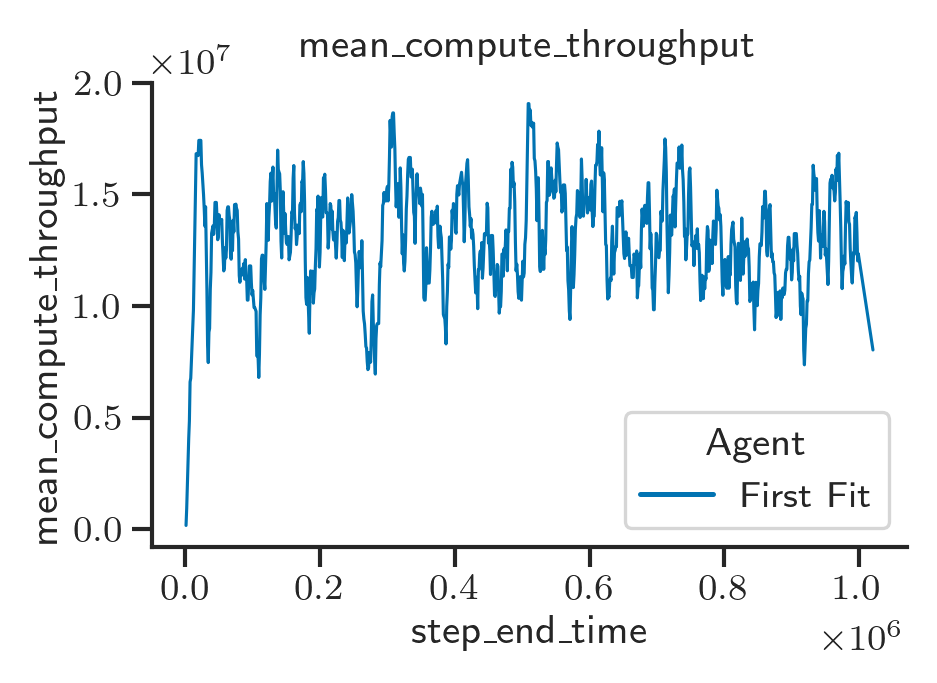

Plotting metric step_end_time -> min=1000.0 | max=1020782.2441915399 | mean=500520.7822441915


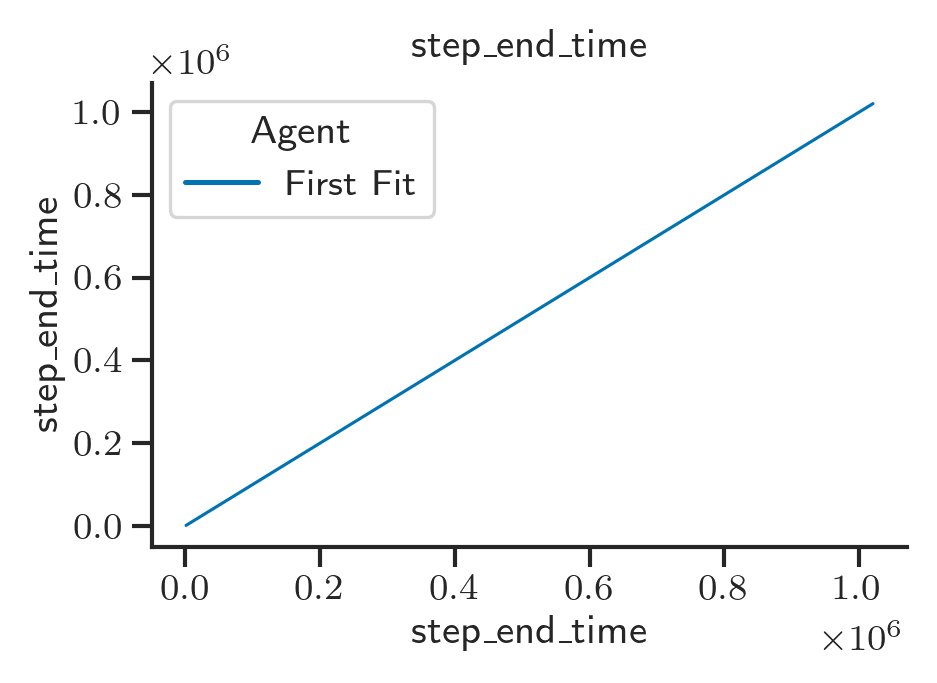

Plotting metric num_jobs_running -> min=1 | max=120 | mean=23.977


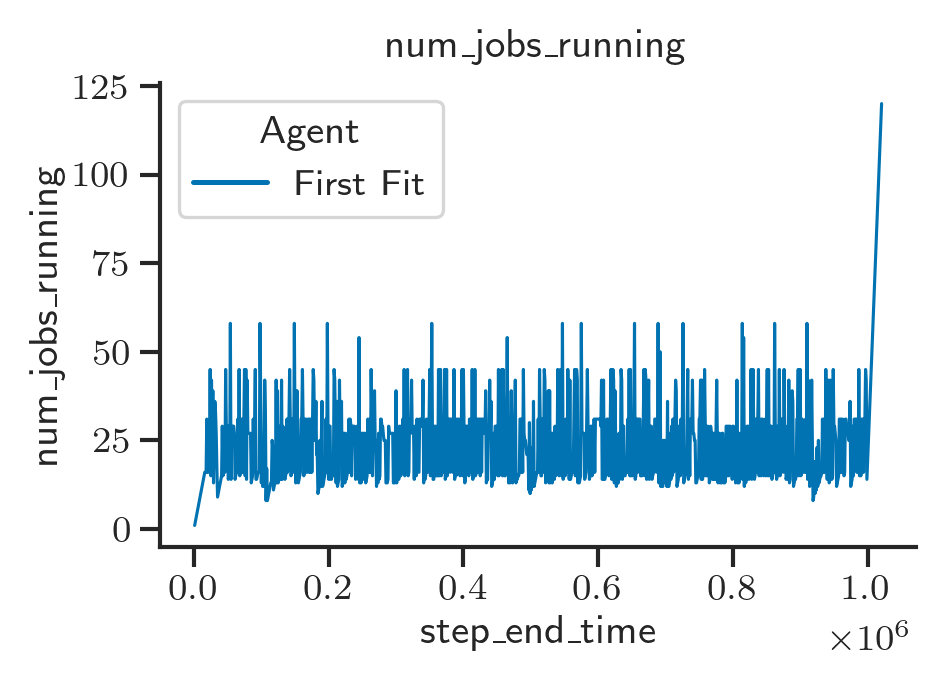

Plotting metric mean_comm_throughput -> min=231533.20903291137 | max=28912315.570871264 | mean=20074426.13291312


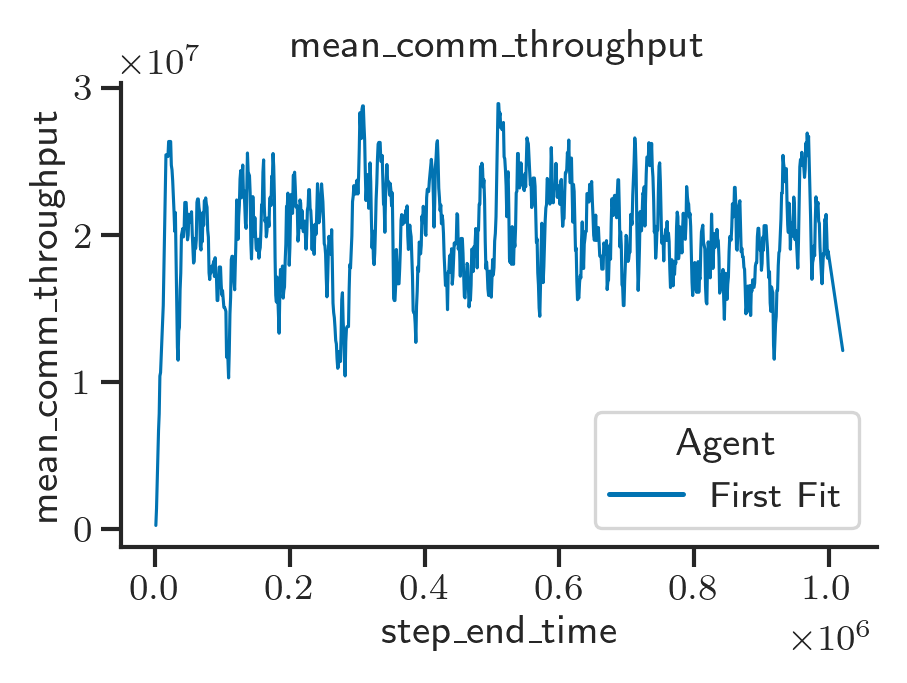

Plotting metric mean_cluster_worker_utilisation_frac -> min=0.06172794999229198 | max=0.9416154201828577 | mean=0.7850144208113091


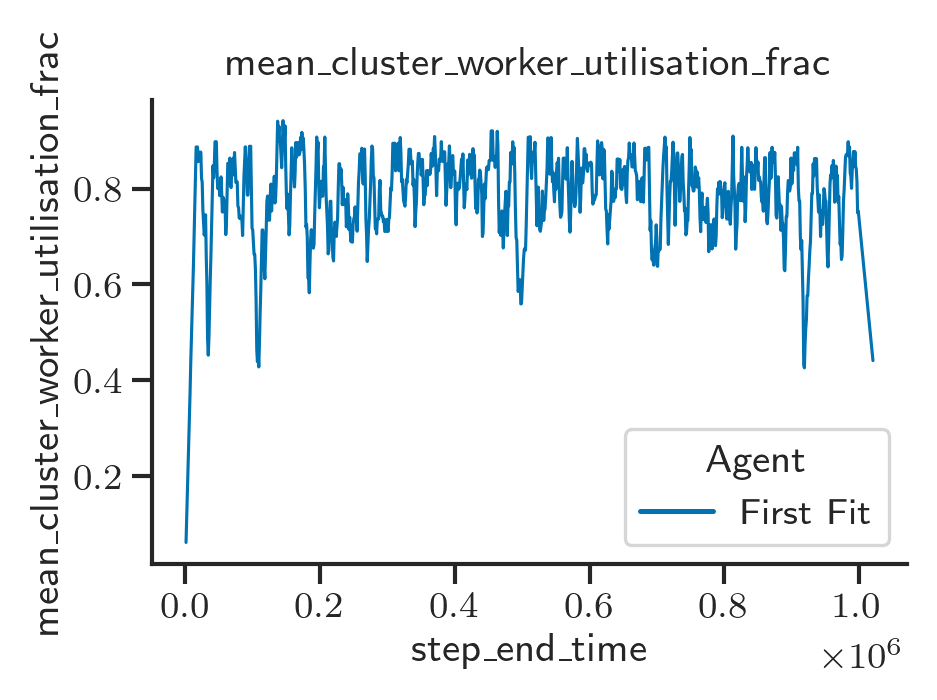

Plotting metric num_jobs_completed -> min=0 | max=15 | mean=0.7


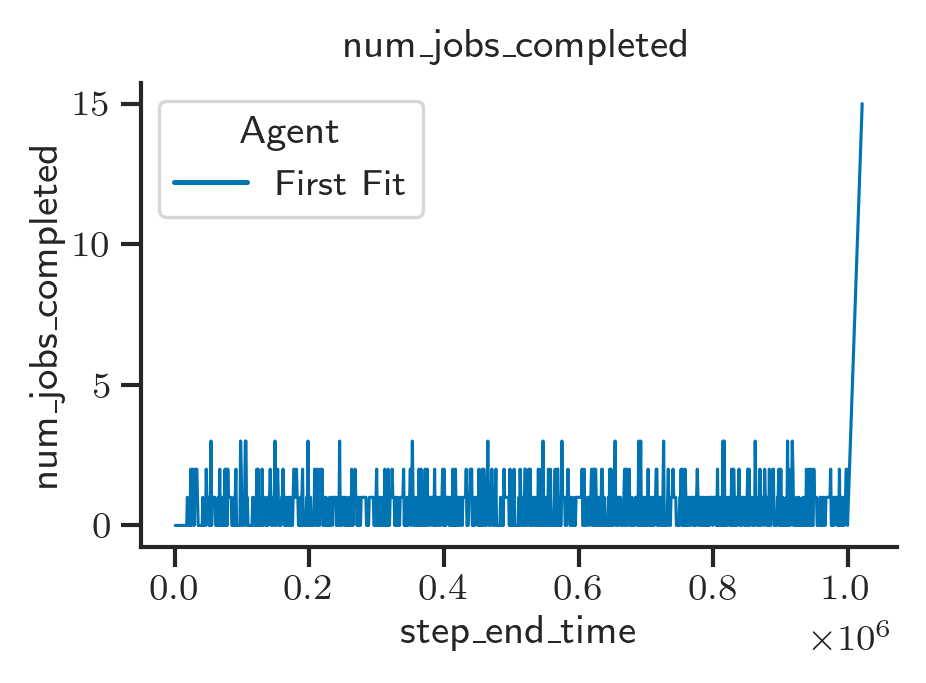

Plotting metric mean_compute_overhead_frac -> min=1.0 | max=1.0 | mean=1.0


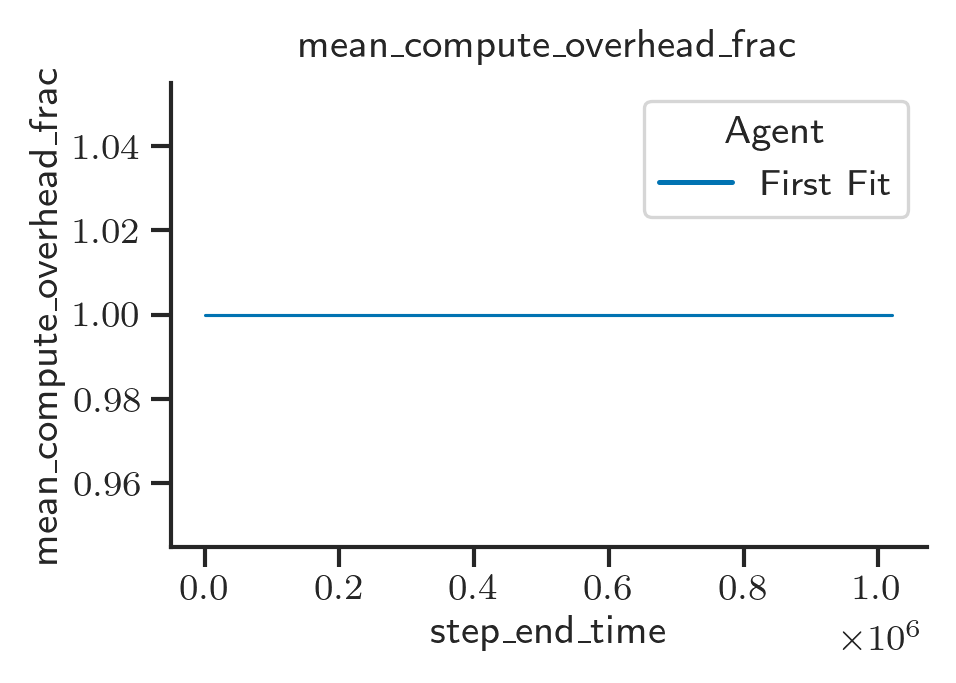

Plotting metric mean_num_mounted_channels -> min=2.0 | max=32.0 | mean=28.357


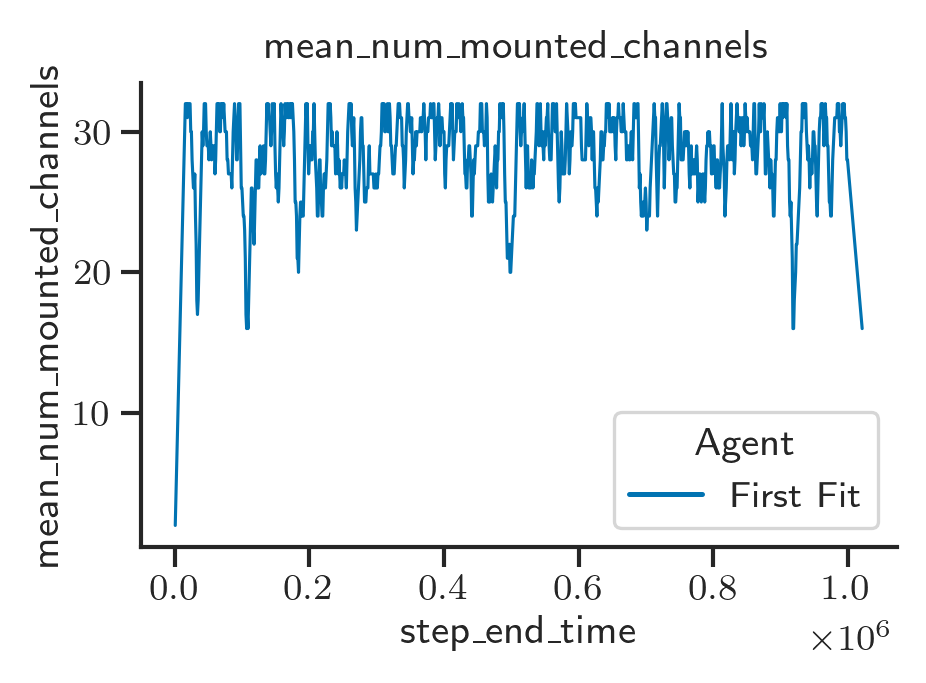

Plotting metric reward -> min=-1.0 | max=-0.2531268250760168 | mean=-0.49710171771720446


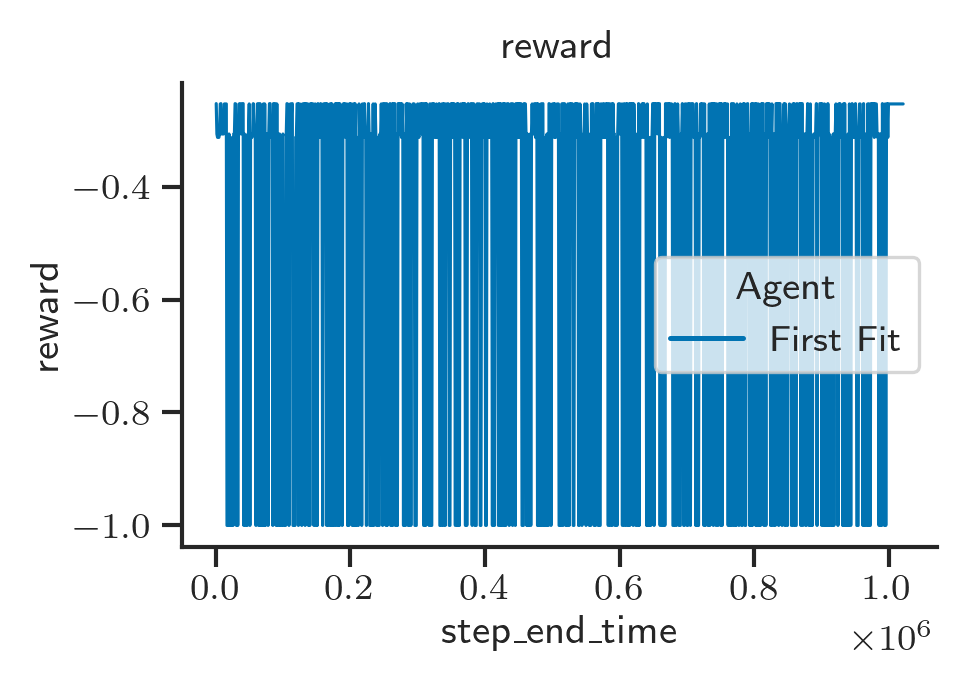

Plotting metric num_jobs_blocked -> min=0 | max=1 | mean=0.3


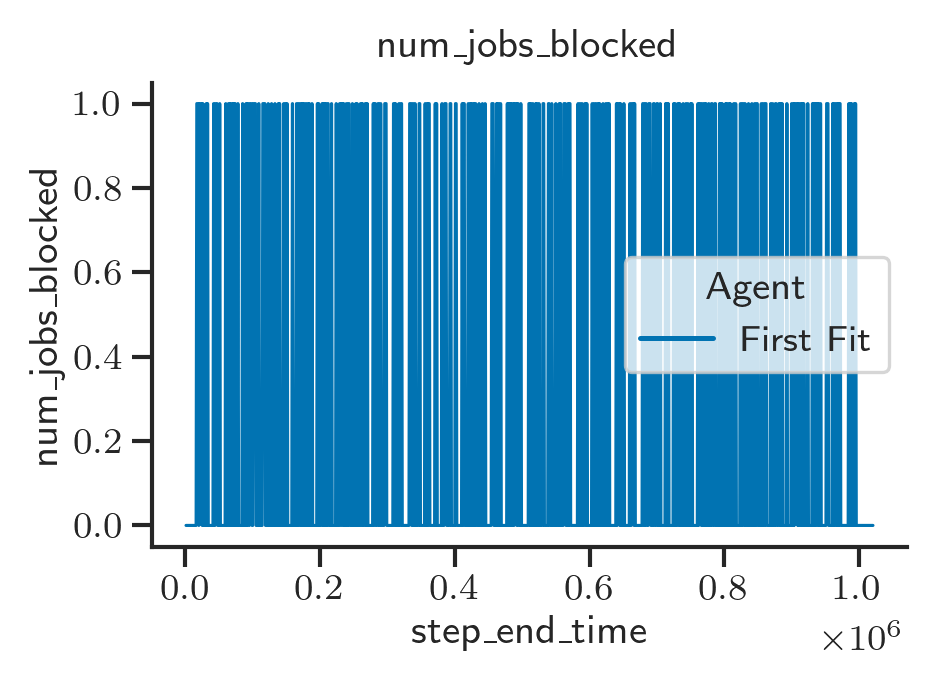

Plotting metric step_start_time -> min=0.0 | max=999000.0 | mean=499500.0


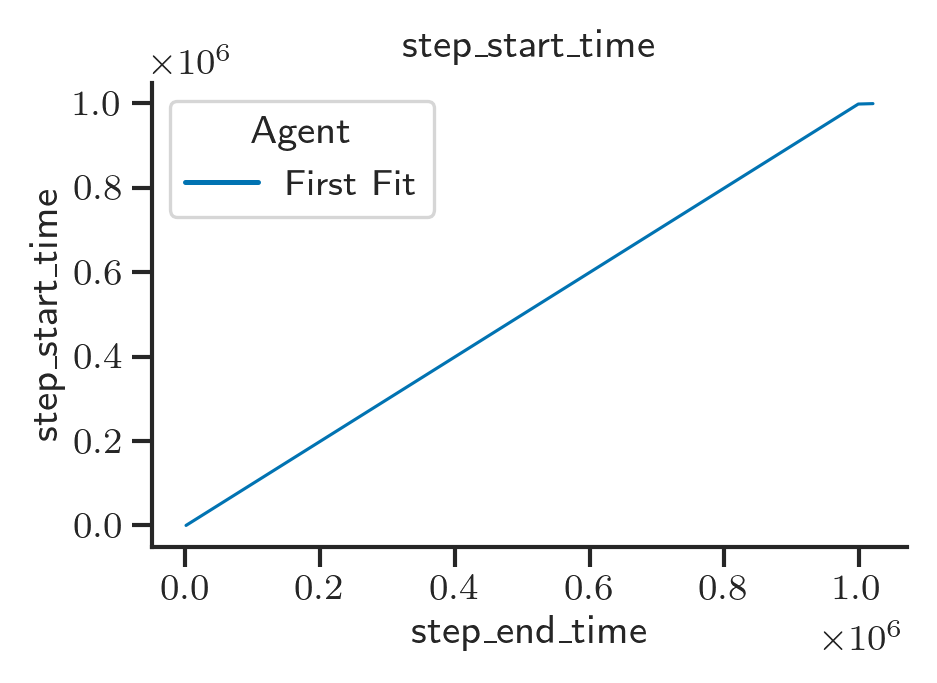

Plotting metric step_counter -> min=0 | max=1698 | mean=836.644


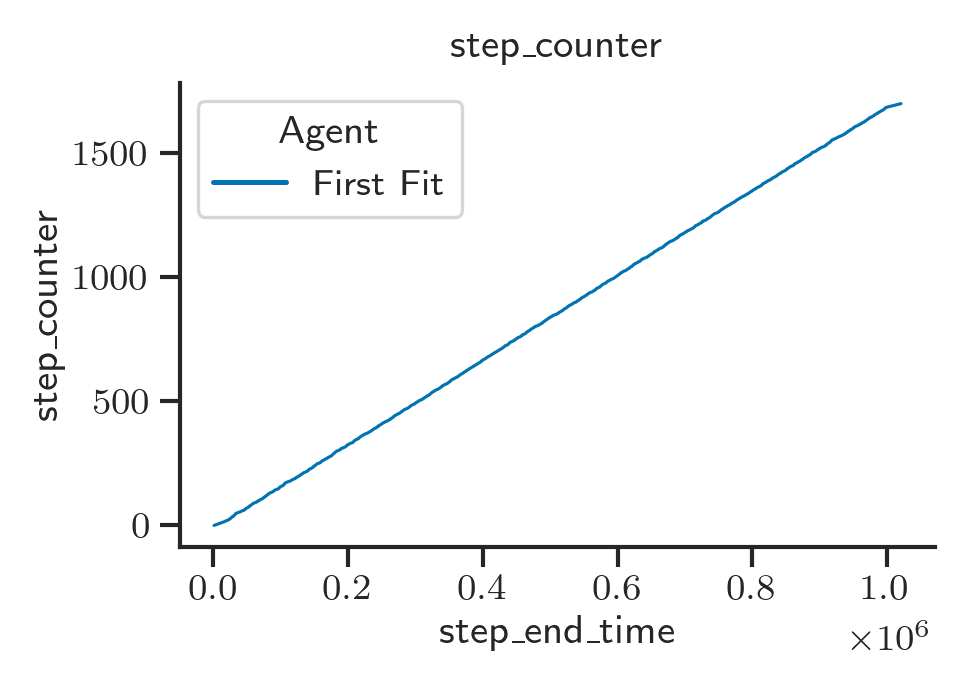

Plotting metric job_queue_length -> min=0 | max=1 | mean=0.999


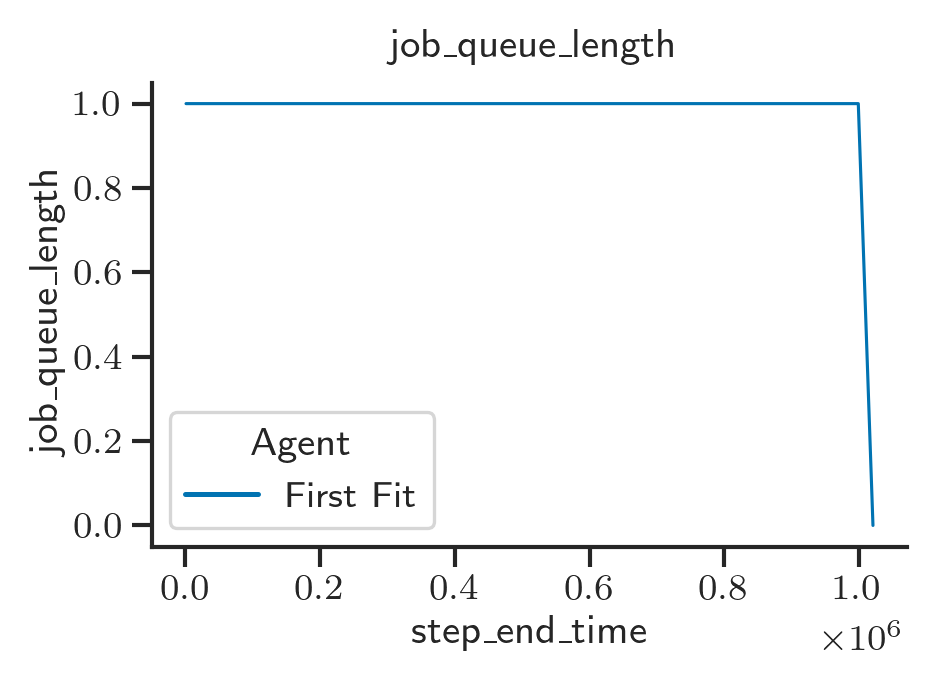

Plotting metric action -> min=0 | max=2 | mean=1.748


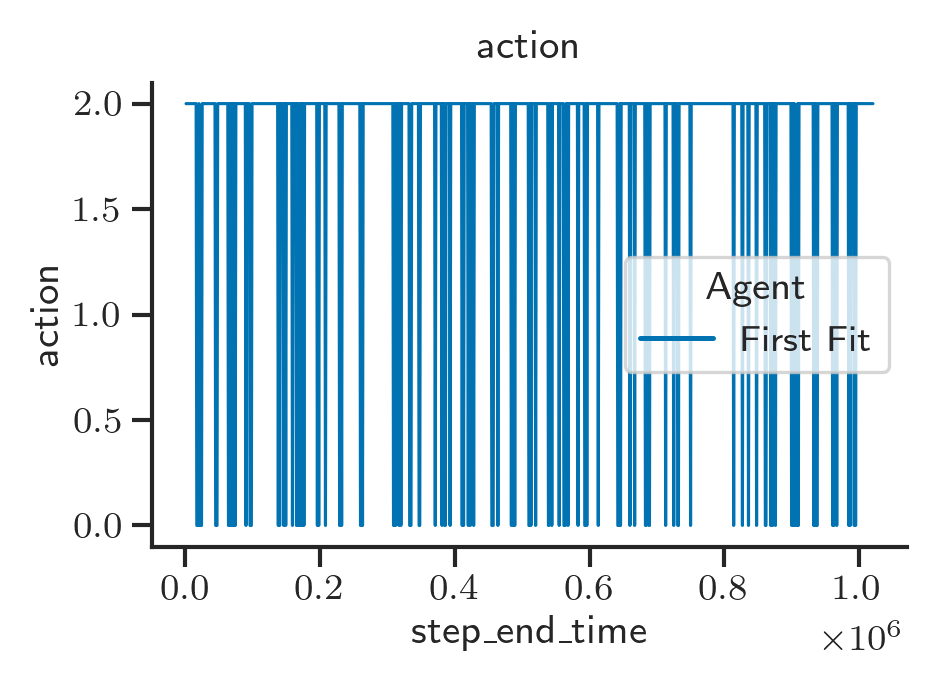

In [28]:
print(f'\n\nEPISODE METRICS')
for metric in episode_metrics:
    barplot(df=episode_stats_df, metric=metric, display_values=display_values)
if len(episode_completion_stats_df) > 0:
    for metric in episode_completion_metrics:
        barplot(df=episode_completion_stats_df, metric=metric)
if len(episode_blocked_stats_df) > 0:
    for metric in episode_blocked_metrics:
        barplot(df=episode_blocked_stats_df, metric=metric)
    
print(f'\n\nSTEP METRICS')
for metric in step_metrics:
    lineplot(df=step_stats_df, metric=metric)